In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Blur image, Threshold

In [9]:
def mean_threshold(img, display=True):
    mean = np.mean(img)

    img[img >= mean] = 255
    img[img < mean] = 0

    if display:
        plt.figure(figsize = [10, 10])
        plt.axis('off')
        plt.imshow(img, cmap="gray")

    return img

In [35]:
def threshold(img, threshold=0.5):
    img[img >= threshold] = 1
    img[img < threshold] = 0

    return img
    

In [42]:
def clean_img(img_path):
    img = cv2.imread(img_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
    # clahe = cv2.createCLAHE(clipLimit=200.0, tileGridSize=(4,4))
    # img = clahe.apply(img)

    for _ in range(5):
        img = cv2.blur(img, (10, 10))
        mean_threshold(img)

    return img 

In [45]:
# Load image
image = cv2.imread('../dataset/handwritten_operators/plus/plus 2.png')
img=image.copy()

# Remove border
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,1))
temp2 = 255 - cv2.morphologyEx(image, cv2.MORPH_CLOSE, horizontal_kernel)
result = cv2.add(temp2, image)

# Convert to grayscale and Otsu's threshold
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray,(5,5),0)
_,thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

cv2.imwrite('img.jpg',thresh)
cv2.imshow('img', thresh)
cv2.waitKey()

In [44]:
image = cv2.imread('../dataset/handwritten_operators/plus/plus 2.png')
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower_green = np.array([100, 43, 20])
upper_green = np.array([130, 255, 255])
mask = cv2.inRange(hsv, lower_green, upper_green)
res = cv2.bitwise_and(image, image, mask=mask)

gray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)
ret, generator = cv2.threshold(gray, 1,255,cv2.THRESH_BINARY)

cv2.imwrite("img.jpg",generator)

True

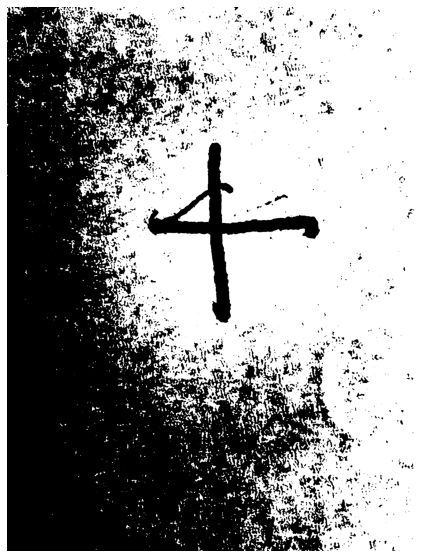

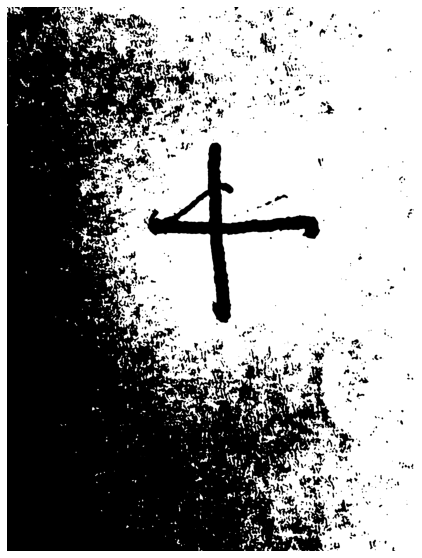

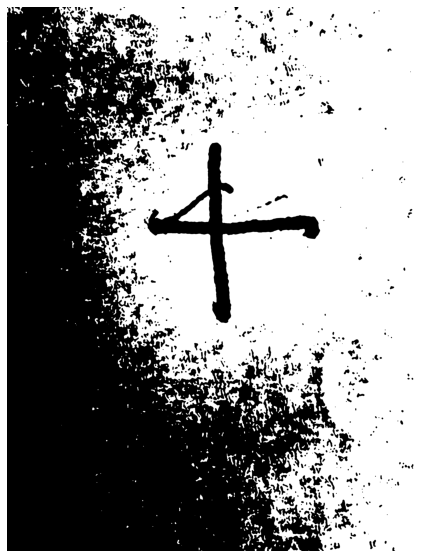

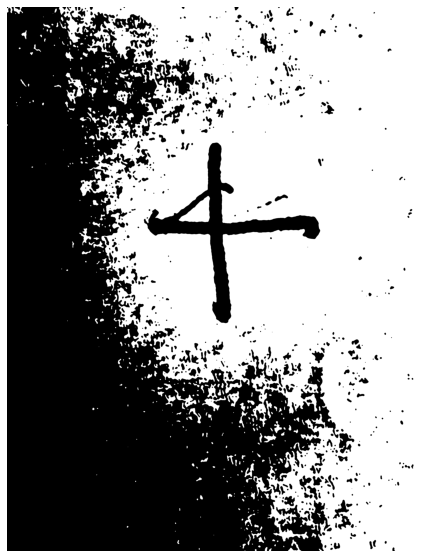

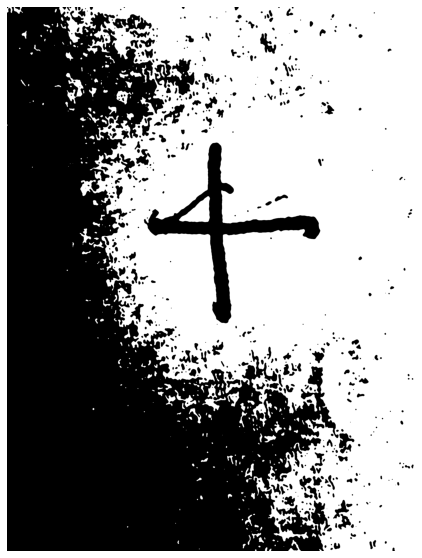

In [43]:
img = clean_img('../dataset/handwritten_operators/plus/plus 2.png')
plt.axis('off')
plt.imshow(img, cmap='gray')

# Center the Image

In [12]:
def center_img(img)
# Assuming the image is clean, choose the bounding box for the symbol


SyntaxError: expected ':' (2625280294.py, line 1)

# Rescale the Image

# Square the Image